## Imports

In [57]:
import os
import sys
import pandas as pd
import seaborn as sns

from typing import List

# Importing functions from src/data
parent_dir = os.path.abspath(os.path.join('..'))
module_path = parent_dir + "/src/data"

if module_path not in sys.path:
    sys.path.append(module_path)

import database as db
import api
import pickle_helpers as pkle
import constants as cnt

## Table of Contents

1. [Data Collection](#data-collection)
2. [Data Validation](#data-validation)
3. [Preprocessing](#preprocessing)
4. [Modeling](#modeling)

### Data Collection

The average price is collected from an API and stored in a postgresql database. In order to retrieve the data in order to begin any analysis we make a query to the database which is handled by the market_data function below.

The data recieved is in the format of a list of 3-tuples containing a unique id, time and price at that time.

In [58]:
# TODO: Improve function to follow dry principles, remove the depedency of raw_material_name and market_data
def create_item_dataframe(raw_material_name: str, region_id: str | int = "0"):
    """ Dataframe constructed from the stats of a material and region id. Will contain stats like
    sell and buy weighted Average, median, min, max, stddev and order counts.

    Args:
        raw_material_name (str): _description_
        region_id (str | int, optional): _description_. Defaults to "0".

    Returns:
        _type_: _description_
    """
    
    # TODO: fix the repetitive code below
    # Historical average buy and sell order stats for raw_material_name
    buy_market_stats = api.market_data(raw_material_name, region_id=region_id)
    buy_order_stats = [i[2] for i in buy_market_stats]
    times = [i[1] for i in buy_market_stats]
    
    sell_market_stats = api.market_data(raw_material_name, region_id=region_id, order_type="sell")
    sell_order_stats = [i[2] for i in sell_market_stats]
    times = [i[1] for i in sell_market_stats]

    # Creating dataframe for buy and sell orders and renaming columns
    df_buy = pd.DataFrame(data=buy_order_stats)
    df_buy.rename(columns=lambda x: "buy_" + x, inplace=True)
    
    df_sell = pd.DataFrame(data=sell_order_stats)
    df_sell.rename(columns=lambda x: "sell_" + x, inplace=True)
    
    df_times = pd.DataFrame(data=times, columns=["time"])

    df = pd.concat([df_times, df_buy, df_sell], axis=1)
    
    # Fixing datatype for all the columns except the time column
    for i in df.iloc[:,1:].columns:
        df[i] = pd.to_numeric(df[i])

    return df

def plot_timeseries(raw_material_name, df, cols):
    df = df[cols]
    data = pd.melt(df, ["time"])
        
    # Plot
    sns.set_theme(style="white")
    plt = sns.lineplot(data=data, x='time', y='value', hue='variable')
    plt.set(title=f"The Price of {raw_material_name}", ylabel="Price (ISK)")

def create_item_plot(raw_material_name: str, region_id: str = "0", cols: List[str]=['time', 'sell_weightedAverage']):
    
    df = create_item_dataframe(raw_material_name, region_id=region_id)
    
    if 'time' not in cols:
        cols.append('time')
        
    plot_timeseries(raw_material_name, df, cols)
    

We will be constructing a dataframe that contains various statistics. There are two features we are mostly considered with sell_weightedAverage and sell_median. However in order to avoid any really high or low sell prices that may portray a unrealistic price to sell the materials at. We will use the weightedAverage as it mitages the bias of those trying to sell for very high or for very low.



In [59]:
# Overview of the data for Chiral Structures
chiral_structures = create_item_dataframe("Chiral Structures", "30000142")
chiral_structures

Command executed successfully
Command executed successfully


,time,buy_weightedAverage,buy_max,buy_min,buy_stddev,buy_median,buy_volume,buy_orderCount,buy_percentile,sell_weightedAverage,sell_max,sell_min,sell_stddev,sell_median,sell_volume,sell_orderCount,sell_percentile
0,2022-05-23 17:43:39.687705,162.526178,490.3,5.53,201.787541,397.6,778909.0,8,490.300000,588.445816,870.0,539.9,96.790840,602.50,8043694.0,34,539.974052
1,2022-05-23 17:51:28.883474,162.526178,490.3,5.53,201.787541,397.6,778909.0,8,490.300000,588.472990,870.0,539.9,96.790840,602.50,8039194.0,34,539.975157
2,2022-05-23 17:53:37.915917,162.526178,490.3,5.53,201.787541,397.6,778909.0,8,490.300000,588.472990,870.0,539.9,96.790840,602.50,8039194.0,34,539.975157
3,2022-05-23 17:56:09.959608,162.526178,490.3,5.53,201.787541,397.6,778909.0,8,490.300000,588.472990,870.0,539.9,96.790840,602.50,8039194.0,34,539.975157
4,2022-05-23 18:00:37.138196,162.526178,490.3,5.53,201.787541,397.6,778909.0,8,490.300000,588.472990,870.0,539.9,96.790840,602.50,8039194.0,34,539.975157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,2022-06-02 22:00:41.153390,312.322343,483.1,5.53,174.121735,476.1,1474152.0,13,480.899760,602.519077,844.8,518.0,92.208775,595.35,4111537.0,34,518.110751
204,2022-06-02 23:00:40.333533,312.407815,483.2,5.53,174.212581,476.1,1474152.0,13,482.609218,597.966707,844.8,517.9,92.790115,595.35,4337777.0,34,517.900000
205,2022-06-03 00:00:41.038297,312.407815,483.2,5.53,174.212581,476.1,1474152.0,13,482.609218,597.970398,844.8,517.9,92.790115,595.35,4337577.0,34,517.900000
206,2022-06-03 01:00:40.245909,312.444447,484.1,5.53,174.252097,476.1,1474152.0,13,483.341842,597.970398,844.8,517.9,92.790115,595.35,4337577.0,34,517.900000


Time series plot with both median and averageWeight. Since we are working with data that is dependent on the time 

Command executed successfully
Command executed successfully


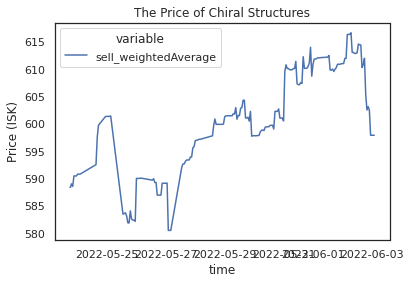

In [60]:
#market_data("Silicon", "0", order_type="sell")


create_item_plot("Chiral Structures", "30000142")


In [61]:
# Return the current price of a material in all regions
def current_price(material_name: str, region_id: int | str = "all", order_type: str = "buy"):
    """_summary_

    Args:
        material_name (str): _description_
        region_id (int | str, optional): _description_. Defaults to "all".
        order_type (str, optional): _description_. Defaults to "buy".
    """
    
    item_id = api.get_item_id(material_name)
    
    command = (f"""
        SELECT data -> '{item_id}' -> '{order_type}'
        FROM market_data
        WHERE region_id = {region_id}
    """)
    
# Determine how much an item has increased by given a time frame
def compute_percentage_gain(material_name: str, region_id: str | int, order_type):
    pass

# Compute the weighted average since we want minimize the effect of unusually high or low material prices

# Create a class that computes various properties of a material throughout a certain period of time

## Data Preprocessing

First we need to check that the data is in chronological order and that the time stamps are equidstant in the time series. The chronological order can be achieved by sorting the dataframe by the timesamps.

In [62]:
# Sort values by timestamp (not necessary but making sure)
df = chiral_structures.sort_values(by='time')

# Checking time intervals

df['time_interval'] = df.time - df.time.shift(1)

df[['time', 'time_interval']]


,time,time_interval
0,2022-05-23 17:43:39.687705,NaT
1,2022-05-23 17:51:28.883474,0 days 00:07:49.195769
2,2022-05-23 17:53:37.915917,0 days 00:02:09.032443
3,2022-05-23 17:56:09.959608,0 days 00:02:32.043691
4,2022-05-23 18:00:37.138196,0 days 00:04:27.178588
...,...,...
203,2022-06-02 22:00:41.153390,0 days 01:00:00.493486
204,2022-06-02 23:00:40.333533,0 days 00:59:59.180143
205,2022-06-03 00:00:41.038297,0 days 01:00:00.704764
206,2022-06-03 01:00:40.245909,0 days 00:59:59.207612


In [63]:
chiral_structures = df[df.time > '2022-05-28']

